In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pydicom
from pathlib import Path
from matplotlib.patches import Rectangle

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = Path('/home/paperspace/data/pneumonia')
sz = 128

In [3]:
def gen(boxes):
    img = np.zeros((sz,sz), dtype=float)
    for x1,y1,x2,y2 in boxes:
        img[y1:y2,x1:x2]=0.2
    img += np.random.rand(sz,sz)*.8
    return np.uint8(img*255)

In [4]:
labels = pd.read_csv(PATH/'stage_1_train_labels.csv')
bboxes = collections.defaultdict(list)
for idx, row in labels.iterrows():
    if (not pd.isna(row['x'])):
        bboxes[row['patientId']].append((row['x'], row['y'],row['width'], row['height']))

In [5]:
def convert(x,y,w,h):
    return(int(x/8),int(y/8),int((x+w)/8),int((y+h)/8))

In [6]:
def convert_all(boxes):
    return [convert(*b) for b in boxes]

In [7]:
ids = labels['patientId'].unique()
sample = np.random.choice(ids,5000,replace=False)
for id in sample:
    boxes = bboxes[id]
    converted = [convert(*X) for X in bboxes[id]]
    img_data = gen(converted)
    pimg = Image.fromarray(img_data)
    img_name = PATH/f'toy/train/{id}.png'
    pimg.save(img_name)

In [8]:
def space_separated(boxes):
    return " ".join([str(x) for box in boxes for x in box])

In [9]:
sample_boxes = [(id+".png", space_separated(convert_all(bboxes[id]))) for id in sample]

In [10]:
sample_df = pd.DataFrame(sample_boxes,columns=['patientId', 'bboxes'])
sample_df.set_index('patientId', inplace=True)
sample_df.to_csv(PATH/'toy/train_labels.csv')

In [11]:
sample_target = [(id, 1 if len(boxes) > 0 else 0) for id,boxes in sample_boxes]
sample_target_df = pd.DataFrame(sample_target,columns=['patientId', 'target'])
sample_target_df.set_index('patientId', inplace=True)
sample_target_df.to_csv(PATH/'toy/train_targets.csv')

In [12]:

sample_df = pd.DataFrame(sample_boxes,columns=['patientId', 'bboxes'])
sample_df.set_index('patientId', inplace=True)
sample_df.to_csv(PATH/'toy/train_labels.csv')

In [13]:
def show_orig(id, boxes, axs):
    pth = PATH/f'train/{id}.dcm'
    dcm_data = pydicom.read_file(str(pth))
    axs.imshow(dcm_data.pixel_array, cmap='bone')
    for box in boxes:
        axs.add_patch(Rectangle(xy=(box[0],box[1]),width=box[2],height=box[3],alpha = 0.5))

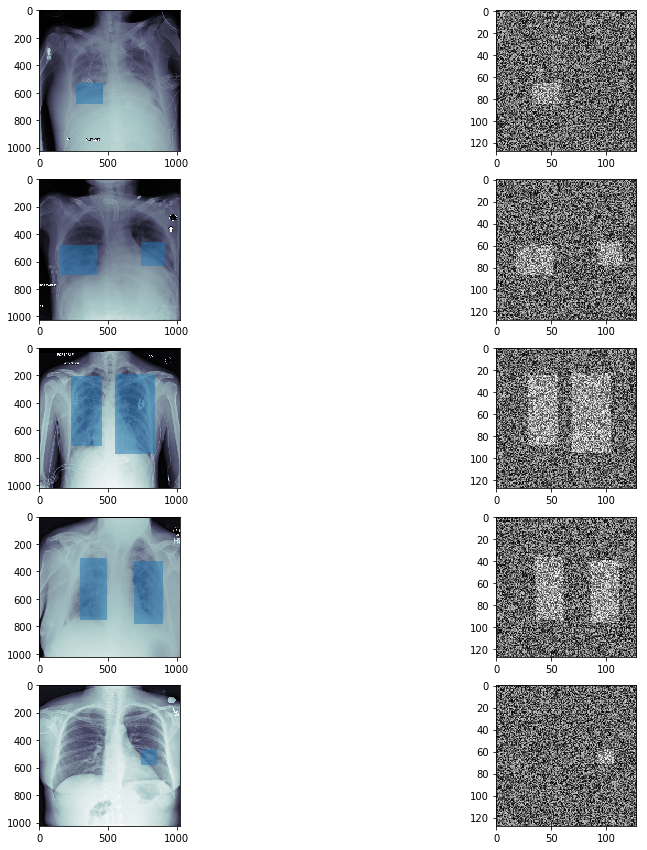

In [14]:
_,axs = plt.subplots(5, 2,figsize=(15,15))
sample_it = iter(sample)
for ax1,ax2 in axs:
    for id in sample_it:
        if len(bboxes[id])>0: break
    show_orig(id,bboxes[id],ax1)
    img_name = PATH/f'toy/train/{id}.png'
    ax2.imshow(PIL.Image.open(img_name), cmap='bone')